# 1. Dataset loading and pickling

In [103]:
from scipy import io as sio
import pickle
import gzip


mat = sio.loadmat('emnist-letters.mat')
data = mat['dataset']

X_train = data['train'][0,0]['images'][0,0]
y_train = data['train'][0,0]['labels'][0,0]
X_test = data['test'][0,0]['images'][0,0]
y_test = data['test'][0,0]['labels'][0,0]
val_start = X_train.shape[0] - X_test.shape[0]
X_val = X_train[val_start:X_train.shape[0],:]
y_val = y_train[val_start:X_train.shape[0]]
X_train = X_train[0:val_start,:]
y_train = y_train[0:val_start]

X_train1 = [X_train]
y_train1 = [y_train]
X_test1  = [X_test]
y_test1  = [y_test]
X_val1   = [X_val]
y_val1   = [y_val]

X_train = list(zip(X_train1,y_train1))
X_test  = list(zip(X_test1,y_test1))
X_val   = list(zip(X_val1,y_val1))
            

f = gzip.open('emnist.pkl.gz','wb')
pickle.dump(X_train+X_val+X_test,f)
f.close()
load_data()
    

((array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[23],
         [ 7],
         [16],
         ...,
         [21],
         [23],
         [25]], dtype=uint8)), (array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[17],
         [12],
         [11],
         ...,
         [13],
         [15],
         [19]], dtype=uint8)), (array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[ 1],
         [ 1],
         [ 1],
         ...,
         [

# 2. Viewing the images

In [4]:

import numpy as np
import pickle
import gzip
import matplotlib
import matplotlib.pyplot as plt

def load_data() :
    f = gzip.open('emnist.pkl.gz','rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return training_data,validation_data,test_data


def load_data_wrapper() :
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    e = np.zeros((27, 1))
    e[j] = 1.0
    return e

#load_data_wrapper()

def plot_images_separately(images):
    fig = plt.figure()
    for j in range(1,20):
        ax = fig.add_subplot(1,19, j)
        ax.matshow(images[j-1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()


def get_images(training_set):
    flattened_images = training_set[0]
    return [np.reshape(f, (-1, 28)) for f in flattened_images]

def main():
    training_set, validation_set, test_set = load_data()
    images = get_images(training_set)
    plot_images_separately(images)
    


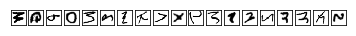

In [5]:
main()

# 3. network.py

Check the accuracy over this network without tuning the hyperparamters

In [97]:

from src import network

training_data, validation_data, test_data = load_data_wrapper()

net = network.Network([784, 100, 27])
net.SGD(training_data, 10, 10, 0.1, test_data)

Epoch 0 : 1194 / 20800
Epoch 1 : 1516 / 20800
Epoch 2 : 1750 / 20800
Epoch 3 : 1880 / 20800
Epoch 4 : 2286 / 20800
Epoch 5 : 2563 / 20800
Epoch 6 : 2630 / 20800
Epoch 7 : 2920 / 20800
Epoch 8 : 2997 / 20800
Epoch 9 : 3104 / 20800


The accuracy for network.py is (3104/20800) i.e 14.92%

# Graph for Training set(Accuracy Vs Cost)

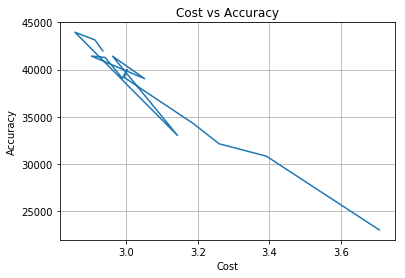

In [100]:
t = training_accuracy
s = training_cost
fig, ax = plt.subplots()
ax.plot(s, t)
ax.set(xlabel='Cost', ylabel='Accuracy', title='Cost vs Accuracy')
ax.grid()
plt.show()

# Graph for Validation set(Accuracy Vs Cost)

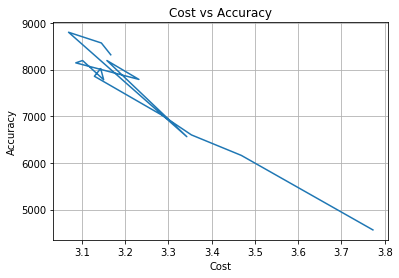

In [95]:

t = evaluation_accuracy
s = evaluation_cost
fig, ax = plt.subplots()
ax.plot(s, t)
ax.set(xlabel='Cost', ylabel='Accuracy', title='Cost vs Accuracy')
ax.grid()
plt.show()

# 4. Improving the network

# network2.py

Check the accuracy by tuning the hyperparamters by changing the value of Learning rate, Lamda and early stopping parameter.

In [53]:
import json
import sys
import numpy as np
import random

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))


class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        return (a-y)


class Network2(object):
    
    def __init__(self, sizes, cost=CrossEntropyCost):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost
        
    def default_weight_initializer(self):
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x) 
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]
     
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, eta,
        lmbda = 0.0,
        evaluation_data=None,
        monitor_evaluation_cost=False,
        monitor_evaluation_accuracy=False,
        monitor_training_cost=False,
        monitor_training_accuracy=False):
       
        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            print ('Epoch %s training complete' % j)
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print ('Cost on training data: {}'.format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print ('Accuracy on training data: {} / {}'.format(
                    accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print ('Cost on evaluation data: {}'.format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print ('Accuracy on evaluation data: {} / {}'.format(
                    self.accuracy(evaluation_data), n_data))
            print('')
        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy
    
    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)
    
    def total_cost(self, data, lmbda, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
        return cost
    
    def save(self, filename):
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()
        
training_data, validation_data, test_data = load_data_wrapper()


# Overfitting with smaller Learning Rate


In [54]:
net = Network2([784,100, 27], cost=CrossEntropyCost)
evaluation_cost, evaluation_accuracy,training_cost, training_accuracy = net.SGD(list(training_data),15,1000,0.3,evaluation_data=list(test_data), monitor_evaluation_accuracy=True, monitor_evaluation_cost=True, monitor_training_accuracy=True,monitor_training_cost=True)
print(evaluation_cost)
percentage_accuracy = (net.accuracy(validation_data)/20800)*100
print(percentage_accuracy)


Epoch 0 training complete
Cost on training data: 2.977528735047458
Accuracy on training data: 52470 / 104000
Cost on evaluation data: 2.9822164078435285
Accuracy on evaluation data: 10415 / 20800

Epoch 1 training complete
Cost on training data: 2.5219065298889958
Accuracy on training data: 59047 / 104000
Cost on evaluation data: 2.5265403801203097
Accuracy on evaluation data: 11856 / 20800

Epoch 2 training complete
Cost on training data: 2.3141106972573846
Accuracy on training data: 62478 / 104000
Cost on evaluation data: 2.3195583877490566
Accuracy on evaluation data: 12398 / 20800

Epoch 3 training complete
Cost on training data: 2.185462260825313
Accuracy on training data: 64069 / 104000
Cost on evaluation data: 2.1966359420232067
Accuracy on evaluation data: 12835 / 20800

Epoch 4 training complete
Cost on training data: 2.0934077527765553
Accuracy on training data: 66367 / 104000
Cost on evaluation data: 2.1046038226447776
Accuracy on evaluation data: 13220 / 20800

Epoch 5 trai

Here we can see that Accuracy is 68.75 % with smaller Learning rate.

# Graph of Validation Set (Accuracy vs Cost)

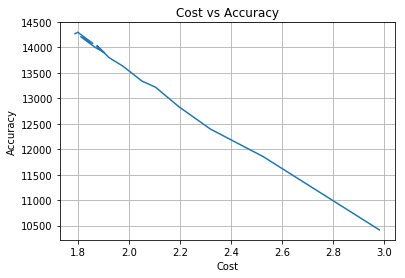

In [55]:
t = evaluation_accuracy
s = evaluation_cost
fig, ax = plt.subplots()
ax.plot(s, t)
ax.set(xlabel='Cost', ylabel='Accuracy', title='Cost vs Accuracy')
ax.grid()
plt.show()


# Graph of Training Set (Accuracy vs Cost)

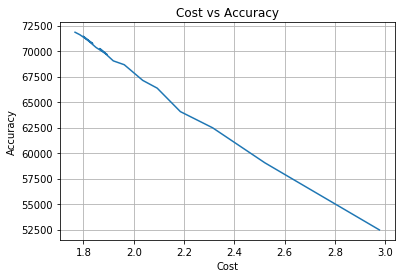

In [56]:
t = training_accuracy
s = training_cost
fig, ax = plt.subplots()
ax.plot(s, t)
ax.set(xlabel='Cost', ylabel='Accuracy', title='Cost vs Accuracy')
ax.grid()
plt.show()

     

# Overfitting with Greater Learning Rate

In [80]:

training_data, validation_data, test_data = load_data_wrapper()
net = Network2([784,100, 27], cost=CrossEntropyCost)
evaluation_cost, evaluation_accuracy,training_cost, training_accuracy = net.SGD(list(training_data),15,1000,1.0,evaluation_data=list(test_data), monitor_evaluation_accuracy=True, monitor_evaluation_cost=True, monitor_training_accuracy=True,monitor_training_cost=True)
percentage_accuracy = (net.accuracy(validation_data)/20800)*100
print(percentage_accuracy)


Epoch 0 training complete
Cost on training data: 3.6815120160961605
Accuracy on training data: 19120 / 104000
Cost on evaluation data: 3.6812314985265284
Accuracy on evaluation data: 3828 / 20800

Epoch 1 training complete
Cost on training data: 3.447866548169658
Accuracy on training data: 25930 / 104000
Cost on evaluation data: 3.4502608829586205
Accuracy on evaluation data: 5182 / 20800

Epoch 2 training complete
Cost on training data: 3.294268869892869
Accuracy on training data: 30880 / 104000
Cost on evaluation data: 3.2878504940340916
Accuracy on evaluation data: 6161 / 20800

Epoch 3 training complete
Cost on training data: 3.1833883694218645
Accuracy on training data: 32464 / 104000
Cost on evaluation data: 3.1824533346264294
Accuracy on evaluation data: 6502 / 20800

Epoch 4 training complete
Cost on training data: 3.20439534833878
Accuracy on training data: 30910 / 104000
Cost on evaluation data: 3.2035800775049994
Accuracy on evaluation data: 6167 / 20800

Epoch 5 training co

Here we can see that Accuracy is 37.39% that means when the learning rate is increased the accuracy goes down. So, when Learning rate was smaller we got a good accuracy i.e 68.75%. 

# Graph of Training Set (Accuracy vs Cost)

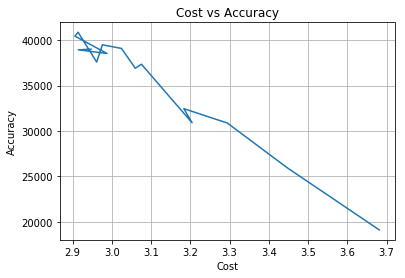

In [81]:
t = training_accuracy
s = training_cost
fig, ax = plt.subplots()
ax.plot(s, t)
ax.set(xlabel='Cost', ylabel='Accuracy', title='Cost vs Accuracy')
ax.grid()
plt.show()

# Graph of Validation Set (Accuracy vs Cost)

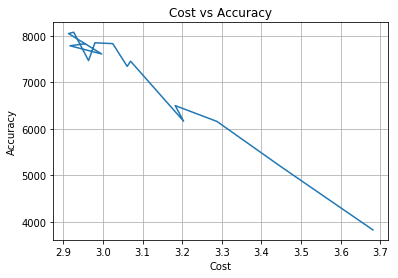

In [82]:
t = evaluation_accuracy
s = evaluation_cost
fig, ax = plt.subplots()
ax.plot(s, t)
ax.set(xlabel='Cost', ylabel='Accuracy', title='Cost vs Accuracy')
ax.grid()
plt.show()

# Regularization with smaller Lamda and Learning rate 

In [83]:

training_data, validation_data, test_data = load_data_wrapper()
net = Network2([784,100, 27], cost=CrossEntropyCost)
evaluation_cost, evaluation_accuracy,training_cost, training_accuracy = net.SGD(list(training_data),15,1000,0.3, lmbda =0.5, evaluation_data=list(test_data), monitor_evaluation_accuracy=True, monitor_evaluation_cost=True, monitor_training_accuracy=True,monitor_training_cost=True)
#print(evaluation_cost)
percentage_accuracy = (net.accuracy(validation_data)/20800)*100
print(percentage_accuracy)


Epoch 0 training complete
Cost on training data: 3.1696366570009946
Accuracy on training data: 48164 / 104000
Cost on evaluation data: 3.1724425944786634
Accuracy on evaluation data: 9654 / 20800

Epoch 1 training complete
Cost on training data: 2.673390376969116
Accuracy on training data: 56145 / 104000
Cost on evaluation data: 2.6792427994326258
Accuracy on evaluation data: 11220 / 20800

Epoch 2 training complete
Cost on training data: 2.4119620153214503
Accuracy on training data: 59482 / 104000
Cost on evaluation data: 2.4223557998129075
Accuracy on evaluation data: 11819 / 20800

Epoch 3 training complete
Cost on training data: 2.307390313528056
Accuracy on training data: 61778 / 104000
Cost on evaluation data: 2.315916106282657
Accuracy on evaluation data: 12289 / 20800

Epoch 4 training complete
Cost on training data: 2.204877616964043
Accuracy on training data: 63238 / 104000
Cost on evaluation data: 2.215078527922651
Accuracy on evaluation data: 12637 / 20800

Epoch 5 training

Here we can see that the Accuracy is 65.54% with smaller value of lamda i.e regularization parameter and learning rate.

#  Graph of Training Set (Accuracy vs Cost)

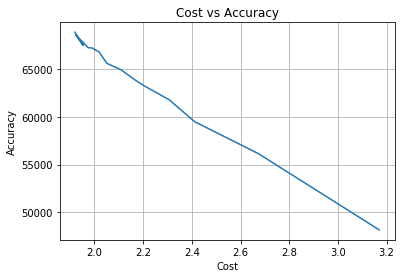

In [84]:

t = training_accuracy
s = training_cost
fig, ax = plt.subplots()
ax.plot(s, t)
ax.set(xlabel='Cost', ylabel='Accuracy', title='Cost vs Accuracy')
ax.grid()
plt.show()


# Graph of Validation Set (Accuracy vs Cost)

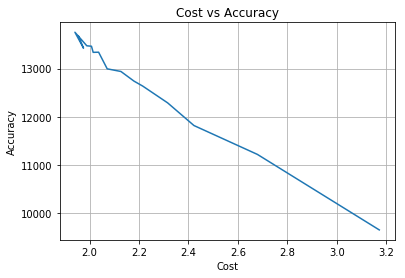

In [85]:
t = evaluation_accuracy
s = evaluation_cost
fig, ax = plt.subplots()
ax.plot(s, t)
ax.set(xlabel='Cost', ylabel='Accuracy', title='Cost vs Accuracy')
ax.grid()
plt.show()

# Regularization with greater Lamda and Learning Rate

In [86]:

training_data, validation_data, test_data = load_data_wrapper()
net = Network2([784,100, 27], cost=CrossEntropyCost)
evaluation_cost, evaluation_accuracy,training_cost, training_accuracy = net.SGD(list(training_data),15,1000,1.0, lmbda =5.0, evaluation_data=list(test_data), monitor_evaluation_accuracy=True, monitor_evaluation_cost=True, monitor_training_accuracy=True,monitor_training_cost=True)
print(evaluation_cost)
percentage_accuracy = (net.accuracy(validation_data)/20800)*100
print(percentage_accuracy)

Epoch 0 training complete
Cost on training data: 3.707175769248347
Accuracy on training data: 23020 / 104000
Cost on evaluation data: 3.7726309524760104
Accuracy on evaluation data: 4565 / 20800

Epoch 1 training complete
Cost on training data: 3.391584765527334
Accuracy on training data: 30831 / 104000
Cost on evaluation data: 3.468388414804001
Accuracy on evaluation data: 6162 / 20800

Epoch 2 training complete
Cost on training data: 3.2593887933339944
Accuracy on training data: 32145 / 104000
Cost on evaluation data: 3.353071325706787
Accuracy on evaluation data: 6601 / 20800

Epoch 3 training complete
Cost on training data: 3.1861748282134017
Accuracy on training data: 34314 / 104000
Cost on evaluation data: 3.2858032331895877
Accuracy on evaluation data: 7019 / 20800

Epoch 4 training complete
Cost on training data: 2.9938931591733104
Accuracy on training data: 39176 / 104000
Cost on evaluation data: 3.128750823188869
Accuracy on evaluation data: 7858 / 20800

Epoch 5 training com

Here we can see that Accuracy is decreasing i.e 40.30% as we are increasing the lamda and learning rate. 

# Graph of Training set (Accuracy vs Cost)  

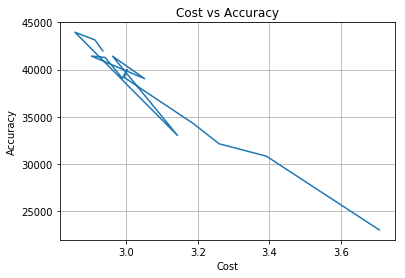

In [88]:

t = training_accuracy
s = training_cost
fig, ax = plt.subplots()
ax.plot(s, t)
ax.set(xlabel='Cost', ylabel='Accuracy', title='Cost vs Accuracy')
ax.grid()
plt.show()

# Graph of Validation Set (Accuracy vs Cost)

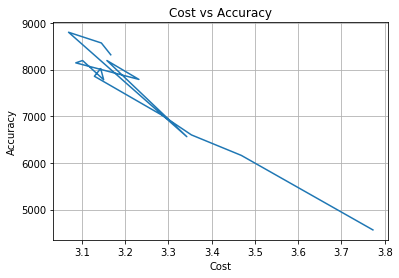

In [89]:
t = evaluation_accuracy
s = evaluation_cost
fig, ax = plt.subplots()
ax.plot(s, t)
ax.set(xlabel='Cost', ylabel='Accuracy', title='Cost vs Accuracy')
ax.grid()
plt.show()

# We can see from network.py and network2.py i.e Improving the network that the Accuracy increases as we tune the hyperparameters like Learning rate and Lamda. So we got the accuracy of network.py as 14.92% and network2.py as 68.75% which says that after tuning the hyperparamters accuracy is increased.